<img src='pics/otus.png'>

In [49]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [50]:
fn = 'orders.csv'

In [51]:
df = pd.read_csv(fn)
df.head(5)

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
0,23.55%,Хроники Амбера. Том 2,357.00,1,2017-03-19 22:25:20,110.00,169108,602051,1,527.00,911531
1,4.07%,Хроники Амбера. Том 1,448.00,1,2017-03-19 22:19:58,19.00,1394744,602047,1,618.00,911531
2,4.17%,Пищеводитель,414.00,1,2017-03-19 20:58:00,65.00,191276,602017,4,1503.00,911587
3,4.17%,Аудиокн. Мясников. &quot;Ржавчина&quot;: что д...,253.00,1,2017-03-19 20:58:00,65.00,157945,602017,4,1503.00,911587
4,4.09%,Инфекции. Как защитить себя и своего ребенка,422.00,1,2017-03-19 20:58:00,65.00,205173,602017,4,1503.00,911587


# 1. Провести EDA
Просмотреть структуру данных, значения каждого признака, поискать особенности в признаках и в данных вцелом

In [52]:
"""
формула рассчета изначальной цены за книгу (без скидки)
"""
def book_price(price, discount):
    #price = nominal_price - (nominal_price/100) * discount
    #price = nominal_price * (1 - discount/100)
    nominal_price = price/(1 - discount/100)
    return round(nominal_price)
    

In [34]:
print(book_price(263,20.06))
print(book_price(316,3.95))

329
329


In [53]:
print(df.count())
df.describe()
#df.sort_values(['NAME', 'date_insert']).head(5)

DISCOUNT_VALUE        553777
NAME                  557811
PRICE                 557818
QUANTITY              557818
date_insert           557818
discount              557818
itemID                557818
orderID               557818
ordered_item_count    557818
price                 557818
user_id               557818
dtype: int64


,PRICE,QUANTITY,discount,itemID,orderID,ordered_item_count,price,user_id
count,557818.00,557818.00,557818.00,557818.00,557818.00,557818.00,557818.00,557818.00
mean,242.73,1.65,519.41,562126.66,662756.84,12.15,2797.27,641006.11
std,261.93,5.05,1032.42,557123.66,37746.44,19.61,7586.23,386439.17
min,0.00,1.00,-1963.00,131823.00,597731.00,1.00,1.00,3.00
25%,92.00,1.00,175.00,178533.00,630532.00,4.00,1053.00,194865.00
50%,185.74,1.00,313.00,196485.00,662686.00,7.00,1389.00,911644.00
75%,313.00,1.00,537.00,727802.00,694208.00,13.00,2276.40,948489.00
max,19792.18,500.00,23851.00,1787508.00,730392.00,277.00,386495.00,998104.00


In [60]:
df.quantile(q=0.99)

PRICE                   1138.00
QUANTITY                  24.00
discount                3921.00
itemID               1653516.00
orderID               729047.00
ordered_item_count       105.00
price                  30031.27
user_id               995314.83
Name: 0.99, dtype: float64

Можем разделить покупателей на группы оптовых, которые берут больше 1 экземпляра книги и розничных

In [69]:
#print(df[df['NAME'].isnull()])
books_df = df.groupby(['NAME']).agg({'QUANTITY': 'sum', 'PRICE': 'sum'}).sort_values('QUANTITY', ascending=False)
books_df.quantile(q=0.99)
#df['NAME'] = df['NAME'].fillna('-')
#df[df.NAME.str.match(r'[a-zA-Z]+')]

QUANTITY     152.00
PRICE      23533.51
Name: 0.99, dtype: float64

1. нужно NaN значения DISCOUNT_VALUE привести к 0
3. DISCOUNT_VALUE  привести к цифровому значению
4. Добавить колонку book_price  где будет цена книги без скидки
5. Разбить дату на поля: день недели, месяц, предпраздничный день (за неделю до праздника),
6. Разбить имя книги на фразы

# 2. Спланировать эксперимент 

Задача:
* сегментация товаров + сегментация пользователей (по товарам, по поведению, скидкам и пр.)

Дополнительнительные задачи (опционально, подумайте о них, могут появиться интересные идеи и находки):
* поиск товаров-заменителей и товаров, дополняющих друг друга
* поиск выбросов среди товаров
* поиск выбросов среди заказов

Эксперимент - составить план, по которому будет проделана исследовательская работа. Примерные пункты плана:
* Составить первичный список признаков, необходимых для решения задачи
* Сгенерировать список новых признаков, которые можно получить из данных
* Применить понижение размерности для визуализации данных
* Применить кластеризацию, визуализировать
* Описание кластера
* Любые другие пункты

# 3. Выполнить подготовку данных для построения модели

Выполнить необходимые преобразования данных

In [125]:
from collections import Counter
docs = []
word_count = Counter()
descs_unique = pd.DataFrame(df['NAME'].unique(), columns=['NAME'])
for idx, row in descs_unique.iterrows():
    desc = row['NAME']
    desc = desc.replace('\xa0',' ').replace('&quot;','')
    tokens = list(filter(lambda x: len(x) > 3, desc.split('. ')))
    docs.append(Counter(tokens))
    for t in tokens:
        word_count[t] += 1

In [164]:
words_most = dict(word_count.most_common(300))
docs_filtered = [{k: v for k, v in d.items() if k in words_most} for d in docs]


In [165]:
from sklearn.feature_extraction import DictVectorizer

v = DictVectorizer(sparse=False)
X = v.fit_transform(docs_filtered)


In [173]:
print(X.shape)
np.count_nonzero(X)

(74633, 300)


21615

In [172]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

inertias = []
silhs = []
kmeans = KMeans(init='k-means++', n_clusters=15)
kmeans.fit(X)
clusters = kmeans.predict(X)
kmeans.inertia_
    

16445.359079632181

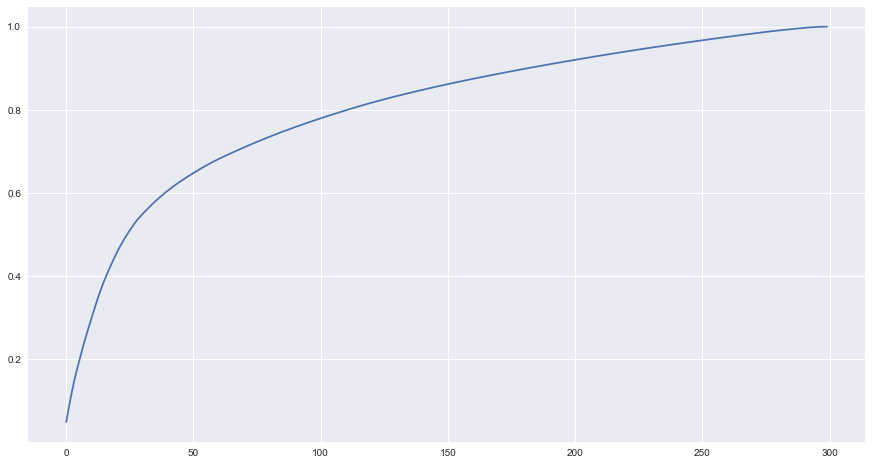

In [175]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

In [176]:
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X)
X_reduced.shape

(74633, 100)

In [185]:
kmeans = KMeans(init='k-means++', n_clusters=15)
kmeans.fit(X_reduced)
clusters = kmeans.predict(X_reduced)
print(kmeans.inertia_)


11387.8324245


In [193]:
print(np.bincount(clusters))

[69017   608   182   494   310   344   379   992   545   217   286   267
   339   391   262]


In [187]:
silhouette_avg = silhouette_score(X_reduced, clusters,sample_size=10000)
print("For n_clusters =", 15, "The average silhouette_score is :", silhouette_avg)


For n_clusters = 15 The average silhouette_score is : 0.840703002961


In [201]:
descs_unique['cluster'] = clusters.T
print(descs_unique[descs_unique['cluster']==14].head(5))
print(descs_unique[descs_unique['cluster']==13].head(5))
print(descs_unique[descs_unique['cluster']==12].head(5))

                                                   NAME  cluster
2192  Физика. Молекулярная физика. Термодинамика. Пр...       14
2193  Физика. Механика. Профильный уровень. 10 класс...       14
2725  Химия. Базовый уровень. 10 класс. Рабочая тетрадь       14
2726  Химия. Базовый уровень. 10 класс. Тетрадь для ...       14
5045      Экология. Базовый уровень. 10-11 кл. Учебник.       14
                                                   NAME  cluster
233   Контрольные работы к учебнику по английскому я...       13
762   Немецкий язык как второй иностранный. 5 класс....       13
763   Немецкий язык как второй иностранный. 5 класс....       13
764   Немецкий язык как второй иностранный. 5 класс....       13
1338         География. 5 класс. Диагностические работы       13
                                                   NAME  cluster
323   Итоговые комплексные работы в начальной школе....       12
966   Полная хрестоматия для начальной школы. 3 клас...       12
1898  Летние задания по р

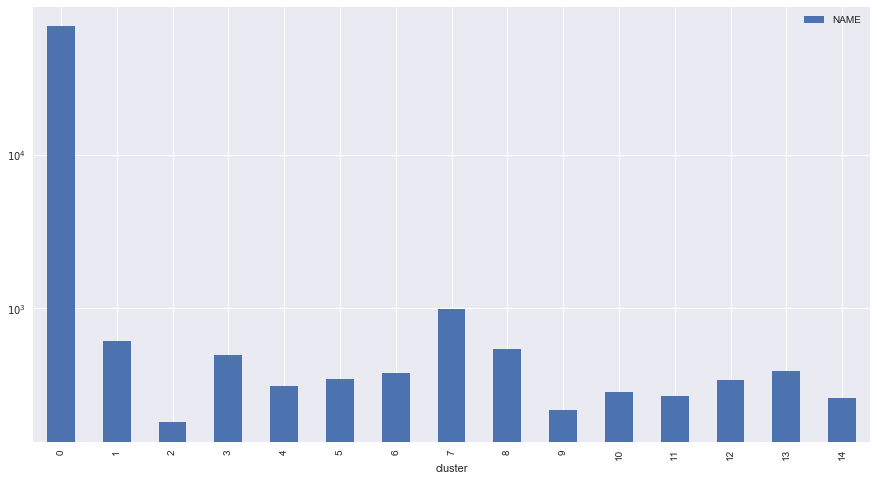

In [223]:
descs_unique.groupby('cluster').count().plot.bar(logy=True)


In [93]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, Imputer, LabelEncoder

def get_discount_num_and_price(df):
    df['DISCOUNT_VALUE'] = df['DISCOUNT_VALUE'].replace('[\%]','',regex=True).astype(float).fillna(0.0)
    df['BOOK_PRICE'] = book_price(df['PRICE'], df['DISCOUNT_VALUE'])
    #df[['PRICE','DISCOUNT_VALUE']].apply(lambda x: book_price(*x), axis=1)
    return df    

def get_name_col(df):
    return df['NAME']

#pipeline = make_union(*[
#    make_pipeline(FunctionTransformer(get_discount_num_and_price, validate=False), Imputer(strategy='mean'), StandardScaler()),
#])
res_df = get_discount_num_and_price(df)                          

In [80]:
res_df.describe()

,DISCOUNT_VALUE,PRICE,QUANTITY,discount,itemID,orderID,ordered_item_count,price,user_id,BOOK_PRICE
count,553777.00,557818.00,557818.00,557818.00,557818.00,557818.00,557818.00,557818.00,557818.00,553777.00
mean,17.85,242.73,1.65,519.41,562126.66,662756.84,12.15,2797.27,641006.11,295.23
std,11.20,261.93,5.05,1032.42,557123.66,37746.44,19.61,7586.23,386439.17,310.10
min,0.00,0.00,1.00,-1963.00,131823.00,597731.00,1.00,1.00,3.00,0.00
25%,7.88,92.00,1.00,175.00,178533.00,630532.00,4.00,1053.00,194865.00,115.00
50%,19.93,185.74,1.00,313.00,196485.00,662686.00,7.00,1389.00,911644.00,235.00
75%,24.24,313.00,1.00,537.00,727802.00,694208.00,13.00,2276.40,948489.00,375.00
max,94.02,19792.18,500.00,23851.00,1787508.00,730392.00,277.00,386495.00,998104.00,23846.00


In [ ]:
res_df

# 4. Провести построение модели 

# 5. Проанализировать результат
получилось или нет, почему, что можно улучшить, можно ли интерпретировать результат

# 6. Повторить при необходимости 

# Подсказки

* Проводить EDA и работу с признаками на всем датасете
* Для построения модели отсеивать данные тем или иным способом (обосновать выбор) - уменьшить объем данных для анализа
* Оформлять для сдачи задания все эксперименты (в том числе неудачные). Так мы сможем увидеть процесс работы над заданием
* Не тратить 90% времени на первый этап. Планировать время так, чтобы успеть поработать над моделью (в равной степени над каждым пунктом).